In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
path = '/content/drive/MyDrive/is665_004/Final/'

In [4]:
train_df = pd.read_csv(path + 'data/train.csv')
test_df = pd.read_csv(path + 'data/test.csv')

In [5]:
train_df

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,...,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,...,Native,US,US,US,Single,0,0,0,Under Median,0
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860
3,TRAIN_00003,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,...,Native,US,US,US,Single,0,0,0,Under Median,850
4,TRAIN_00004,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,...,Native,US,US,US,Head of Household (HOH),0,0,0,Unknown,570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,TRAIN_19995,33,M,High graduate,Children or Armed Forces,52,Manufacturing (Durable),Handlers/Cleaners,White,All other,...,Native,US,US,US,Single,0,0,0,Under Median,1300
19996,TRAIN_19996,20,F,College,Full-Time,12,Education,Admin Support (include Clerical),White,Mexican-American,...,Native,US,Mexico,Mexico,Nonfiler,0,0,0,Under Median,850
19997,TRAIN_19997,22,M,College,Children or Armed Forces,52,Transportation,Technicians & Support,White,All other,...,Native,US,US,US,Single,0,0,0,Unknown,999
19998,TRAIN_19998,76,F,High graduate,Not Working,0,Not in universe or children,Unknown,White,All other,...,Native,US,Scotland,England,Single,0,0,0,Under Median,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      20000 non-null  object
 1   Age                     20000 non-null  int64 
 2   Gender                  20000 non-null  object
 3   Education_Status        20000 non-null  object
 4   Employment_Status       20000 non-null  object
 5   Working_Week (Yearly)   20000 non-null  int64 
 6   Industry_Status         20000 non-null  object
 7   Occupation_Status       20000 non-null  object
 8   Race                    20000 non-null  object
 9   Hispanic_Origin         20000 non-null  object
 10  Martial_Status          20000 non-null  object
 11  Household_Status        20000 non-null  object
 12  Household_Summary       20000 non-null  object
 13  Citizenship             20000 non-null  object
 14  Birth_Country           20000 non-null  object
 15  Bi

## train 데이터셋 전처리

### 범주형 변수 label encoding

In [7]:
label_encoder = LabelEncoder()

categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
  train_df[col] = label_encoder.fit_transform(train_df[col].astype(str))

### 상관관계 기반 feature selection

In [8]:
correlation_matrix = train_df.corr().abs()
correlation_matrix

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
ID,1.000000,0.008429,0.002362,0.012284,0.000263,0.000578,0.006030,0.011509,0.008566,0.002564,...,0.005496,0.007447,0.008903,0.004086,0.009865,0.013664,0.009466,0.007843,0.003845,0.008760
Age,0.008429,1.000000,0.038892,0.267565,0.179449,0.206218,0.052182,0.124579,0.053450,0.086805,...,0.061182,0.035017,0.019237,0.020456,0.280926,0.044156,0.053384,0.107565,0.040451,0.124795
Gender,0.002362,0.038892,1.000000,0.030605,0.003425,0.076096,0.040227,0.040741,0.010982,0.024941,...,0.022237,0.017245,0.008590,0.018111,0.088306,0.051484,0.062227,0.009609,0.050970,0.093893
Education_Status,0.012284,0.267565,0.030605,1.000000,0.102765,0.109949,0.014813,0.105499,0.010528,0.014907,...,0.003265,0.014586,0.003786,0.011825,0.075069,0.003991,0.009711,0.006892,0.016496,0.031286
Employment_Status,0.000263,0.179449,0.003425,0.102765,1.000000,0.069562,0.006774,0.053366,0.010061,0.013652,...,0.035374,0.026513,0.017751,0.016750,0.039390,0.002199,0.009535,0.022857,0.013170,0.033009
Working_Week (Yearly),0.000578,0.206218,0.076096,0.109949,0.069562,1.000000,0.102496,0.566186,0.043816,0.081281,...,0.017902,0.001957,0.056557,0.057049,0.218456,0.053362,0.056658,0.002209,0.049282,0.419628
Industry_Status,0.006030,0.052182,0.040227,0.014813,0.006774,0.102496,1.000000,0.245686,0.007089,0.004573,...,0.015892,0.023321,0.010923,0.004078,0.058219,0.006169,0.009149,0.007327,0.016589,0.083369
Occupation_Status,0.011509,0.124579,0.040741,0.105499,0.053366,0.566186,0.245686,1.000000,0.052846,0.034223,...,0.009292,0.001760,0.041329,0.037394,0.162515,0.016767,0.022439,0.010149,0.015122,0.348873
Race,0.008566,0.053450,0.010982,0.010528,0.010061,0.043816,0.007089,0.052846,1.000000,0.081591,...,0.152752,0.071172,0.066398,0.057474,0.016312,0.007836,0.002274,0.031288,0.005009,0.024573
Hispanic_Origin,0.002564,0.086805,0.024941,0.014907,0.013652,0.081281,0.004573,0.034223,0.081591,1.000000,...,0.054963,0.231598,0.290670,0.272545,0.003242,0.010351,0.013606,0.029285,0.012931,0.073829


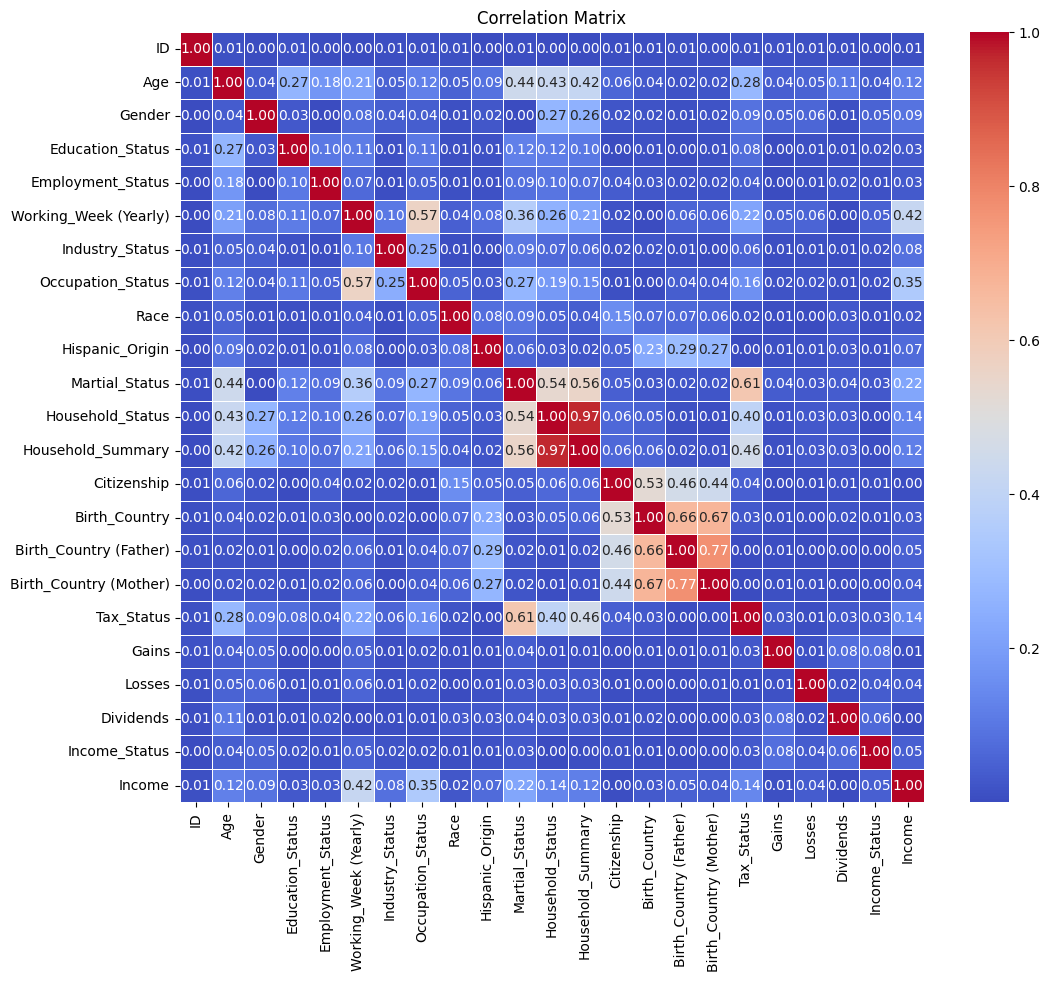

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [10]:
threshold = 0.1 # 임계값 설정
relevant_features = correlation_matrix['Income'][correlation_matrix['Income'] > threshold].index.tolist()
relevant_features

['Age',
 'Working_Week (Yearly)',
 'Occupation_Status',
 'Martial_Status',
 'Household_Status',
 'Household_Summary',
 'Tax_Status',
 'Income']

In [11]:
train_df_subset = train_df[relevant_features]

## target column 분리

In [12]:
X_train = train_df_subset.drop(columns=['Income'])
y_train = train_df_subset['Income']

## 모델 훈련

In [13]:
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=False)
}

In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = {}

for model_name, model in models.items():
    rmse_scores[model_name] = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # 표준화
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)

        model.fit(X_train_fold_scaled, y_train_fold)

        # 검증 데이터에 대한 예측 및 RMSE 계산
        val_preds = model.predict(X_val_fold_scaled)
        rmse = mean_squared_error(y_val_fold, val_preds, squared=False)
        rmse_scores[model_name].append(rmse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 7
[LightGBM] [Info] Start training from score 556.153500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 7
[LightGBM] [Info] Start training from score 555.873750
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [15]:
# 모델별 k-fold cross validation의 평균 RMSE 출력
for model_name, scores in rmse_scores.items():
    print(f"{model_name}: Mean RMSE - {np.mean(scores)}")

Random Forest: Mean RMSE - 658.9183144550436
Gradient Boosting: Mean RMSE - 605.9630141015924
XGBoost: Mean RMSE - 631.5085231750603
LightGBM: Mean RMSE - 608.9672901504614
CatBoost: Mean RMSE - 614.1283595072963


In [16]:
# 가장 낮은 RMSE를 가진 모델 선택하여 전체 훈련 데이터로 재학습
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

best_model_name = min(rmse_scores, key=rmse_scores.get)
best_model = models[best_model_name]
best_model.fit(X_scaled, y_train)

GradientBoostingRegressor(random_state=42)

## test 데이터셋 전처리

In [17]:
test_ids = test_df['ID']

In [18]:
for col in categorical_cols:
  test_df[col] = test_df[col].map(lambda x: 'Unknown' if x not in label_encoder.classes_ else x)
  test_df[col] = label_encoder.transform(test_df[col].astype(str))

In [19]:
test_df = test_df[relevant_features[:-1]]

## test 데이터셋 예측

In [20]:
test_preds = best_model.predict(scaler.transform(test_df))

## submission 파일 생성

In [21]:
submission_df = pd.DataFrame({'ID': test_ids, 'Income': test_preds})
submission_df
#submission_df.to_csv(path + 'submission/submission_20240402(3).csv', index=False)

,ID,Income
0,TEST_0000,621.792655
1,TEST_0001,722.169763
2,TEST_0002,738.412450
3,TEST_0003,885.179630
4,TEST_0004,470.988344
...,...,...
9995,TEST_9995,930.463776
9996,TEST_9996,915.476967
9997,TEST_9997,527.334305
9998,TEST_9998,470.988344
